In [ ]:
import torch
import torchvision  # type: ignore
import torch.nn as nn
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [ ]:
batch_size_train = 128
batch_size_test = 1000

In [ ]:
train_loader = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST(root='./data', train=True, download=True,
                                   transform=torchvision.transforms.Compose([
                                       torchvision.transforms.ToTensor(),
                                       torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                   ])), batch_size=batch_size_train, shuffle=True
    )
test_loader = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST(root='./data', train=False, download=True,
                                   transform=torchvision.transforms.Compose([
                                       torchvision.transforms.ToTensor(),
                                       torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                   ])), batch_size=batch_size_test, shuffle=True
    )

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 14050785.16it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 427600.12it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3914566.14it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 7672383.72it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.5)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.5)
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.5)
        )
        self.flc_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32, 25),
            nn.LeakyReLU(0.2),
            nn.Linear(25, 15),
            nn.LeakyReLU(0.2),
            nn.Linear(15, 10)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.flc_block(x)

        return x


In [ ]:
def train(device, model, train_loader, learning_rate=0.05, epochs=5):
    loss_fn = nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
    #optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    history = []
    for epoch in tqdm(range(epochs)):
        epoch_loss = 0.0
        for x, y in train_loader:
            optimizer.zero_grad()
            x, y = x.to(device), y.to(device)
            pred = model(x)

            loss = loss_fn(pred, y)
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()

        average_loss = epoch_loss / len(train_loader)
        history.append(average_loss)

        print(f'Epoch {epoch + 1}, Loss: {average_loss}')
    plt.plot(range(0, epochs), history)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss per Epoch')
    plt.show()

In [ ]:
def test(model, device, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = correct / total
    print(f"Accuracy on the test set: {accuracy:.2%}")

    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
model

Net(
  (conv_block1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
  )
  (conv_block3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
  )
  (flc_block): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=32, out_features=25, bias=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=25, out_features=15, bia

  3%|▎         | 1/35 [00:13<07:35, 13.41s/it]

Epoch 1, Loss: 6183.162843590352


  6%|▌         | 2/35 [00:26<07:18, 13.28s/it]

Epoch 2, Loss: 1038.6294382497954


  9%|▊         | 3/35 [00:40<07:07, 13.37s/it]

Epoch 3, Loss: 37.61449231877764


 11%|█▏        | 4/35 [00:53<06:57, 13.46s/it]

Epoch 4, Loss: 989.7755708048846


 14%|█▍        | 5/35 [01:07<06:46, 13.56s/it]

Epoch 5, Loss: 819.8943556529373


 17%|█▋        | 6/35 [01:20<06:31, 13.52s/it]

Epoch 6, Loss: 16.244797296615552


 20%|██        | 7/35 [01:34<06:15, 13.42s/it]

Epoch 7, Loss: 769.8529213763503


 23%|██▎       | 8/35 [01:47<05:59, 13.31s/it]

Epoch 8, Loss: 638.3727724409815


 26%|██▌       | 9/35 [02:00<05:43, 13.22s/it]

Epoch 9, Loss: 5976.770868408146


 29%|██▊       | 10/35 [02:13<05:29, 13.17s/it]

Epoch 10, Loss: 146.38788129322563


 31%|███▏      | 11/35 [02:26<05:15, 13.16s/it]

Epoch 11, Loss: 416.6755777269538


 34%|███▍      | 12/35 [02:39<05:02, 13.16s/it]

Epoch 12, Loss: 868.8441874724207


 37%|███▋      | 13/35 [02:52<04:49, 13.15s/it]

Epoch 13, Loss: 1908.3899167331297


 40%|████      | 14/35 [03:05<04:36, 13.16s/it]

Epoch 14, Loss: 62.93197611095046


 43%|████▎     | 15/35 [03:19<04:23, 13.17s/it]

Epoch 15, Loss: 600.4365192008679


 46%|████▌     | 16/35 [03:32<04:10, 13.20s/it]

Epoch 16, Loss: 764.6189849503767


 49%|████▊     | 17/35 [03:45<03:57, 13.20s/it]

Epoch 17, Loss: 160.76866721090224


 51%|█████▏    | 18/35 [03:58<03:44, 13.20s/it]

Epoch 18, Loss: 1169.8901386649877


 54%|█████▍    | 19/35 [04:12<03:31, 13.24s/it]

Epoch 19, Loss: 840.7628447620599


 57%|█████▋    | 20/35 [04:25<03:19, 13.27s/it]

Epoch 20, Loss: 46.23805821628205


 60%|██████    | 21/35 [04:38<03:06, 13.32s/it]

Epoch 21, Loss: 5578.817948800923


 63%|██████▎   | 22/35 [04:52<02:52, 13.31s/it]

Epoch 22, Loss: 307.18239575611756


 66%|██████▌   | 23/35 [05:05<02:38, 13.22s/it]

Epoch 23, Loss: 355.45494272561467


 69%|██████▊   | 24/35 [05:18<02:24, 13.16s/it]

Epoch 24, Loss: 1223.0916528437438


 71%|███████▏  | 25/35 [05:31<02:11, 13.19s/it]

Epoch 25, Loss: 90.12829436320486


 74%|███████▍  | 26/35 [05:44<01:57, 13.11s/it]

Epoch 26, Loss: 1270.8479394506035


 77%|███████▋  | 27/35 [05:57<01:44, 13.06s/it]

Epoch 27, Loss: 367.3032566448773


 80%|████████  | 28/35 [06:10<01:31, 13.10s/it]

Epoch 28, Loss: 19.216569737839038


 83%|████████▎ | 29/35 [06:23<01:18, 13.12s/it]

Epoch 29, Loss: 1821.427345882855


 86%|████████▌ | 30/35 [06:36<01:05, 13.12s/it]

Epoch 30, Loss: 1760.1693664364723


 89%|████████▊ | 31/35 [06:50<00:52, 13.21s/it]

Epoch 31, Loss: 44.45744484269034


 91%|█████████▏| 32/35 [07:03<00:39, 13.20s/it]

Epoch 32, Loss: 318.2509152863834


 94%|█████████▍| 33/35 [07:16<00:26, 13.15s/it]

Epoch 33, Loss: 817.3164064269076


 97%|█████████▋| 34/35 [07:29<00:13, 13.11s/it]

Epoch 34, Loss: 88.03209870405543


100%|██████████| 35/35 [07:42<00:00, 13.21s/it]

Epoch 35, Loss: 7110.2912380492


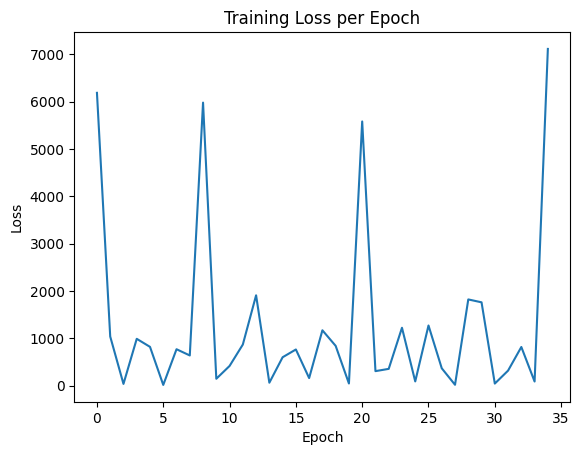

In [ ]:
train(device, model, train_loader, epochs=35)

Accuracy on the test set: 57.20%


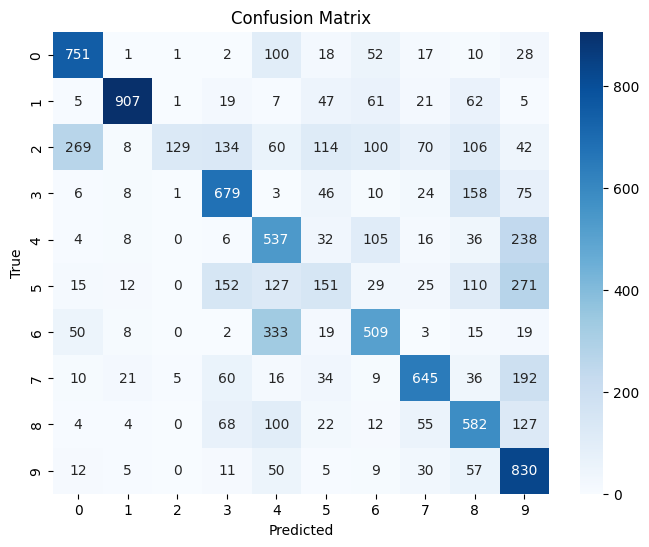

In [ ]:
test(model, device, test_loader)

In [ ]:
def validate(model, device, test_loader):
    model.eval()
    with torch.no_grad():
        dataset = test_loader.dataset
        random_index = np.random.randint(0, len(dataset))
        single_example = dataset[random_index]
        images, labels = single_example[0], single_example[1]
        images = images.unsqueeze(0).to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        print(f"Предсказано: {predicted.item()}, Реально: {labels}")


In [ ]:
dataset = test_loader.dataset
random_index = int(np.random.random()*len(dataset))
single_example = dataset[random_index]

In [ ]:
validate(model, device, test_loader)

Предсказано: 1, Реально: 1
